### Crank-Nicolson Scheme for Schrödinger Equation
**Problem**: Solve the Schrödinger equation $i(\partial\psi/\partial t)=\hat{H}\psi$ $(0\leq x\leq L$, $0\leq t)$ where $m=1/2$ and $\hbar=1$, using an implicit Crank-Nicolson scheme that preserves the wave function normalization. The inital condition and boundary conditions are given as $u(x,0)=N\exp{(-a(x-x_0)^2)}\exp{(-l(x-x_0)i)}$ and $u(0,t)=u(L,t)=0$. The Hamiltonian $\hat{H}=\partial^2/\partial x^2+V(x)$ requires discretization with an average between the explicit and implicit centered finite difference approximations for the second-order spatial derivative. The Crank Nicolson scheme for solving the Schrödinger equation implements this Hamiltonian discretization that preserves wave function normalization. The following derivation comes from Numerical Recipes$^\textbf{1}$:

$$i\frac{\partial\psi}{\partial t}=\hat{H}\psi\Rightarrow\psi(x,t)=e^{-i\hat{H}t}\psi(x,0)$$
The unstable explicit FTCS scheme yields $\psi^{n+1}_k=(1-i\hat{H}\Delta t)\psi^n_k$ and the stable implicit BTCS scheme yields $\psi^{n+1}_k=(1+i\hat{H}\Delta t)^{-1}\psi^n_k$, but the implicit scheme does not preserve normalization. The unitary operator for the finite difference representation of $e^{-i\hat{H}t}$ comes from the linear expansion terms of the equivalent operator $e^{-i\hat{H}t/2}/e^{i\hat{H}t/2}$

$$e^{-i\hat{H}t}\simeq\frac{1-\frac{1}{2}i\hat{H}\Delta t}{1+\frac{1}{2}i\hat{H}\Delta t}$$
$$(1+i\hat{H}\Delta t)\psi^{n+1}_k=(1-i\hat{H}\Delta t)\psi^n_k$$

The unitary operator $\hat{U}$ satisfies $U^\dagger U=UU^\dagger=I$ where $U^\dagger$ denotes the Hermitian conjugate or complex transpose. The operator $\hat{U}$ preserves normalization and therefore probability amplitudes in quantum mechanics.
$$(U|x\rangle)^\dagger(U|x\rangle)=(\langle x|U^\dagger)(U|x\rangle)=\langle x|(U^\dagger U)|x\rangle=\langle x|I|x\rangle=\langle x|x\rangle$$

$^\textbf{1}$ <small>William H. Press, Saul A. Teukolsky. Numerical Recipes in C : the Art of Scientific Computing. Cambridge University Press, 1992.</small>

In [5]:
using LinearAlgebra, PyPlot, PyCall
anim = pyimport("matplotlib.animation");

In [6]:
@time begin
    T, L = 240, 400
    dt, dx = 0.2, 0.2
    Nt, Nx = Int(T/dt + 1), Int(L/dx + 1)
    r, a, l = dt/dx^2, 0.002, 0.5

    N = (2*a/π)^(1/4) # Normalization
    f(x) = N*exp(-a*(x - 50)^2)*exp(-l*(x - 50)im)
    x = range(0, stop=L, step=dx)
    ψ = zeros(Complex, Nt, Nx)
    ψ[1, :] = f.(x); ψ[1, 1] = ψ[1, end] = 0
    
    V = [(L/2 - 25 < x[k] < L/2 + 25 ? 0.5*2/r : 0.0) for k = 1:Nx]
    
    A = zeros(Nx, Nx)
    dl = du = ComplexF64[-(r/2) for k = 1:(Nx - 1)]
    d = [(im + r - (r/2)*V[k]) for k = 1:Nx]
    A = Tridiagonal(dl, d, du)

    for n = 1:(Nt - 1)
        RHS = (r/2)*[ψ[n, 2:end]; 0] + (im - r)*ψ[n, :] + (r/2)*[0; ψ[n, 1:(end - 1)]] + (r/2)*V.*ψ[n, :]
        ψ[n + 1, :] = A\RHS; ψ[n + 1, 1] = ψ[n + 1, end] = 0
    end
end;

  4.256022 seconds (49.66 M allocations: 1.786 GiB, 59.19% gc time)


#### Wave Function Normalization (Unitary Operator)

In [7]:
# Composite Numerical Integration (Quadrature)
function compQNC(f::Vector, a::Real, b::Real, n::Real)
    I, m, w = 0, 3, (1/6)*[1, 4, 1]
    dx = (b - a)/(n*(m - 1))
    x = collect(a:dx:b)
    for i = 1:(m - 1):(n*(m - 1))
        I += w' * f[i:(m + i - 1)]
    end
    return I * (m - 1)dx
end
compQNC(abs.(ψ[end, :]).^2, 0, 400, 1000)

0.9996543005519829

#### Schrödinger Time Evolution (Visualization)

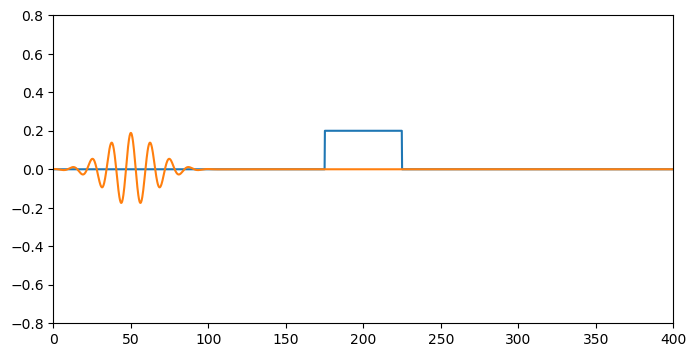

In [8]:
figure(figsize=(8, 4))
xlim(0, L); ylim(-0.8, 0.8)
plot(x, V); plot(x, ψ[1, :]);